In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [3]:
import matplotlib.pyplot as plt
from orthogonal_dfa.spliceai.best_psams_for_lssi import (
    train_and_evaluate_lssi_psams,
    plot_accuracies,
    accuracy_vs_loss,
)

In [4]:
don = train_and_evaluate_lssi_psams("donor", num_batches=100_000, lr=3e-4)
acc = train_and_evaluate_lssi_psams("acceptor", num_batches=100_000, lr=3e-4)

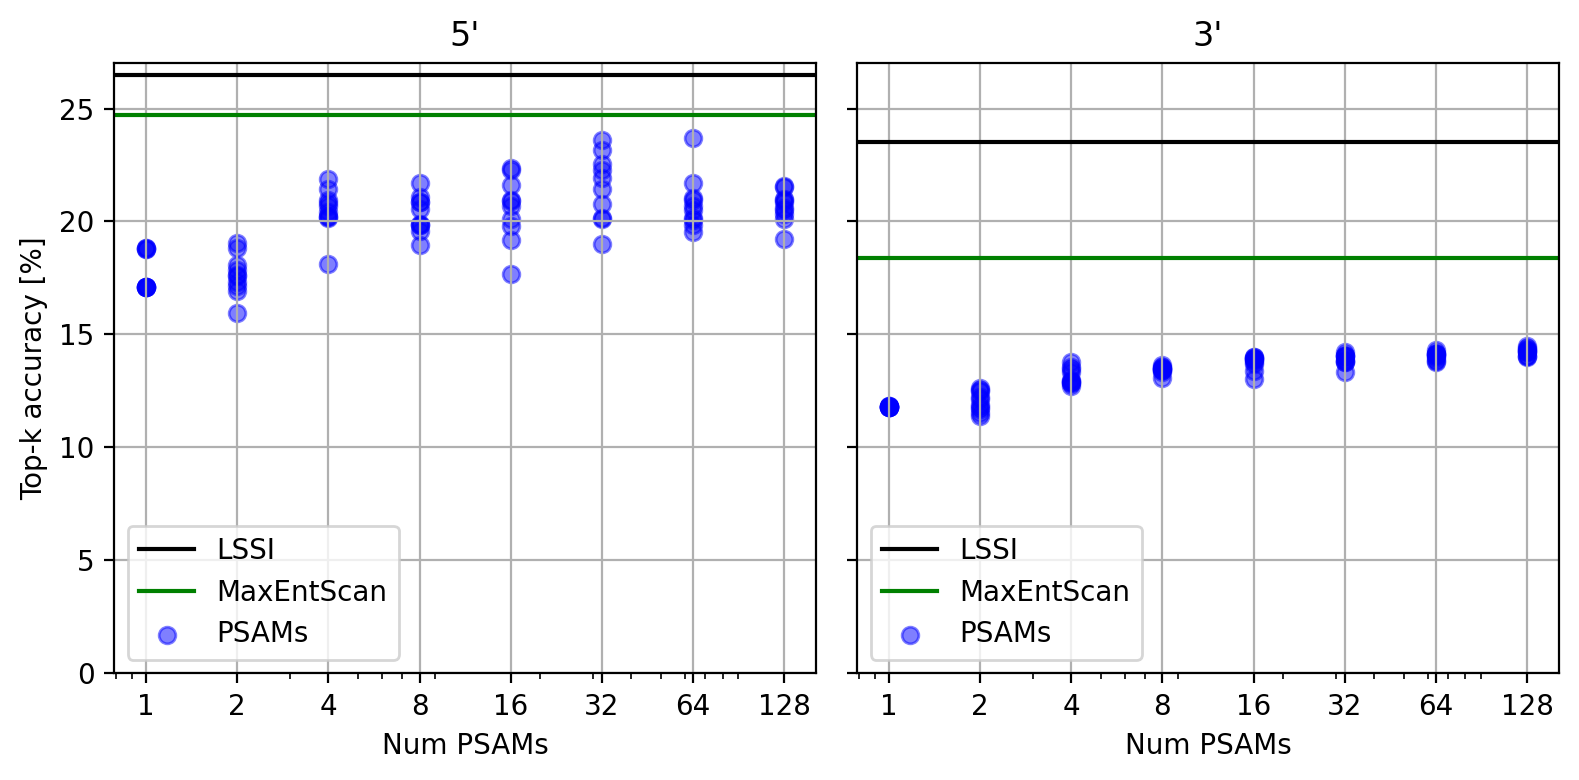

In [5]:
_, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=200, sharey=True, tight_layout=True)

plot_accuracies(don, 26.5, 24.7, "5'", ax=axs[0])
plot_accuracies(acc, 23.5, 18.4, "3'", ax=axs[1])
axs[0].set_ylabel("Top-k accuracy [%]")
for ax in axs:
    ax.grid()
plt.show()

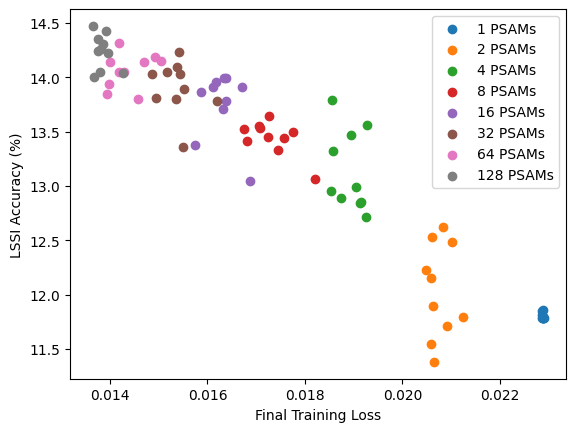

In [6]:
accuracy_vs_loss(acc)

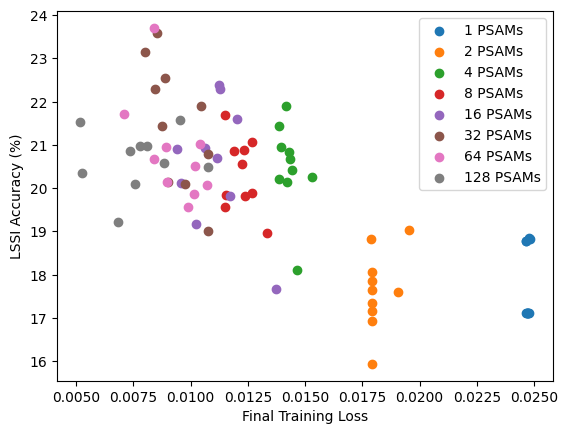

In [7]:
accuracy_vs_loss(don)